In [ ]:
import sys
sys.path.insert(1,'/home/kwu/anaconda3/lib/python3.6/site-packages')
import pytraj as pt
from sklearn.cluster import KMeans
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [11]:
DIR = '/hdd/kingsley/GPU0_DATA/1Z0Q/water_test/'
TRAJ='/hdd/kingsley/GPU0_DATA/1Z0Q/water_test/1us_IDPS_h2o.dcd'
TOP='/hdd/kingsley/GPU0_DATA/1Z0Q/water_test/1z0q_water.prmtop'

### Load Trajectory

In [12]:
traj = pt.iterload(TRAJ,TOP)
frameidx=np.array(range(traj.n_frames))
traj

pytraj.TrajectoryIterator, 10000 frames: 
Size: 4.302263 (GB)
<Topology: 19248 atoms, 6251 residues, 6210 mols, PBC with box type = ortho>
           

#### superimpose the trajectory to the refertence frame

In [13]:
pt.superpose(traj, ref=0, mask='@CA')

pytraj.TrajectoryIterator, 10000 frames: 
Size: 4.302263 (GB)
<Topology: 19248 atoms, 6251 residues, 6210 mols, PBC with box type = ortho>
           

### Cluster by RMSD of C$_\alpha$ Cartesian coodinates

#### Extract Cartesian coordinates of C$_\alpha$ atoms from "traj"

In [14]:
CA = traj['@CA'] # CA trajectory
CA_2d = CA.xyz.reshape(CA.n_frames,CA.n_atoms*3)
RMSD = pt.rmsd(CA, ref=0, nofit=True)

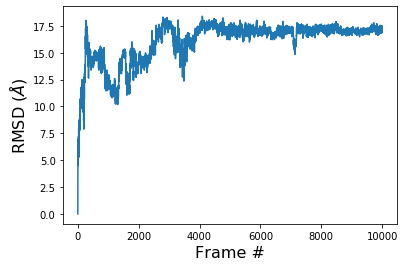

In [15]:
fig=plt.figure()
plt.plot(range(len(RMSD)), RMSD)
plt.xlabel('Frame #', fontsize = 16)
plt.ylabel('RMSD ($\AA$)', fontsize = 16)
plt.show()
fig.savefig(DIR+'/RMSD_CA.pdf')

#### optimize k by an elbow curve

In [16]:
Kdistant=[]
n_datas = len(CA_2d)
for k in range(1,20):
    tmp=0
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(RMSD.reshape(-1,1))
    labels = kmeans.predict(RMSD.reshape(-1,1))
    C = kmeans.cluster_centers_
    

    tmp+=np.linalg.norm(RMSD.reshape(-1,1)[labels==(k-1)] - C[(k-1)], axis=1).sum()
    Kdistant.append([k,tmp/n_datas])
Kdistant=np.array(Kdistant)

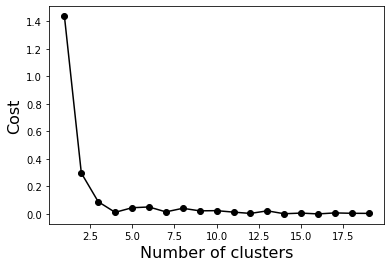

In [17]:
fig=plt.figure()
plt.plot(Kdistant[:,0],Kdistant[:,1], marker='o', color='k')
plt.xlabel('Number of clusters', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()
fig.savefig(DIR+'/Elbow_curve_CA.pdf')

In [18]:
nc=12 # change the optimized number of clusters here according to the elbow curve
kmeans = KMeans(n_clusters=nc, init='k-means++').fit(RMSD.reshape(-1,1))
labels = kmeans.predict(RMSD.reshape(-1,1))
C = kmeans.cluster_centers_

#### Color each cluster

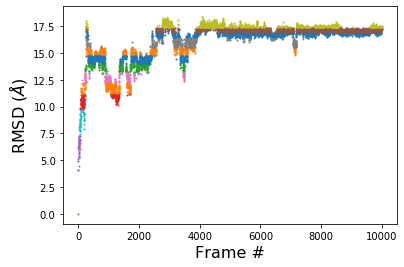

In [19]:
fig=plt.figure()

for i in range(len(C)):
    plt.scatter(np.array(range(len(RMSD)))[labels==i], RMSD[labels==i], s=1)
plt.xlabel('Frame #', fontsize = 16)
plt.ylabel('RMSD ($\AA$)', fontsize = 16)
plt.show()
fig.savefig(DIR+'/RMSD_CA_colored.pdf')

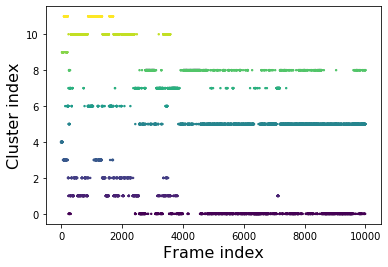

In [20]:
%matplotlib inline
fig=plt.figure()
plt.scatter(range(len(RMSD)), labels, c= labels, s = 2)
plt.xlabel('Frame index', fontsize = 16)
plt.ylabel('Cluster index', fontsize = 16)
plt.show()
fig.savefig(DIR+'/RMSD_CA_cluster_index.pdf')

#### Export separate trajectories of clusters

In [21]:
Out = DIR+'/RMSD_CA' # make sure you've created this ooutput folder in your computer

In [22]:
for i in range(nc):
    traj[frameidx[labels==i].tolist()].save(Out+'/rmsd_ca_%d.dcd'%(i+1), overwrite=True)
    print("cluster %d"%(i+1), "%d frames"%len(frameidx[labels==i]))

cluster 1 2309 frames
cluster 2 676 frames
cluster 3 460 frames
cluster 4 228 frames
cluster 5 44 frames
cluster 6 3091 frames
cluster 7 242 frames
cluster 8 550 frames
cluster 9 1331 frames
cluster 10 51 frames
cluster 11 708 frames
cluster 12 310 frames


In [23]:
Out

'/hdd/kingsley/GPU0_DATA/1Z0Q/water_test//RMSD_CA'